<a href="https://colab.research.google.com/github/KzBrain/project/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Endoscopy_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

from PIL import Image

#Сегментация изображении
Сегментация изображении полости желудочно-кишечного тракта при помощи нейронной сети позволяет нам определять патологические варианты изменения.

In [ ]:
image_folder = '/content/sample_data/Images'
mask_folder = '/content/sample_data/Musk'

# Получение всех путей к изображениям и маскам
image_paths = sorted(glob.glob(os.path.join(image_folder, '*.jpg')))
mask_paths = sorted(glob.glob(os.path.join(mask_folder, '*.jpg')))

# Проверка, что файлы найдены
print("Количество изображений:", len(image_paths))
print("Количество масок:", len(mask_paths))

# Вывод первых нескольких путей для проверки
print("Пути к изображениям:", image_paths[:5])
print("Пути к маскам:", mask_paths[:5])

Количество изображений: 55
Количество масок: 55
Пути к изображениям: ['/content/sample_data/Images/131368cc17e44240_28955.jpg', '/content/sample_data/Images/131368cc17e44240_28956.jpg', '/content/sample_data/Images/131368cc17e44240_28957.jpg', '/content/sample_data/Images/131368cc17e44240_28958.jpg', '/content/sample_data/Images/131368cc17e44240_28959.jpg']
Пути к маскам: ['/content/sample_data/Musk/131368cc17e44240_28955.jpg', '/content/sample_data/Musk/131368cc17e44240_28956.jpg', '/content/sample_data/Musk/131368cc17e44240_28957.jpg', '/content/sample_data/Musk/131368cc17e44240_28958.jpg', '/content/sample_data/Musk/131368cc17e44240_28959.jpg']


In [ ]:
def load_data(image_paths, mask_paths, img_size):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = imread(img_path)
        mask = imread(mask_path)

        # Преобразование в черно-белый формат
        if len(img.shape) == 3:
            img = img[..., 0]

        if len(mask.shape) == 3:
            mask = mask[..., 0]

        img_resized = resize(img, img_size, mode='constant', preserve_range=True)
        mask_resized = resize(mask, img_size, mode='constant', preserve_range=True)

        images.append(img_resized)
        masks.append(mask_resized)

    print("Number of images loaded:", len(images)) # Check if images were loaded
    print("Number of masks loaded:", len(masks)) # Check if masks were loaded

    images = np.expand_dims(np.array(images), axis=-1) / 255.0
    masks = np.expand_dims(np.array(masks), axis=-1) / 255.0

    return images, masks

In [ ]:
def unet_model(input_size=(128, 128, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
img_size = (128, 128)
images, masks = load_data(image_paths, mask_paths, img_size)

print("Размеры изображений:", images.shape)
print("Размеры масок:", masks.shape)

Number of images loaded: 55
Number of masks loaded: 55
Размеры изображений: (55, 128, 128, 1)
Размеры масок: (55, 128, 128, 1)


In [ ]:
history = model.fit(images, masks, validation_split=0.2, epochs=10, batch_size=8)

Epoch 1/10
6/6 [==============================] - 32s 2s/step - loss: 0.7135 - accuracy: 0.5555 - val_loss: 0.6099 - val_accuracy: 0.5079
Epoch 2/10
6/6 [==============================] - 1s 136ms/step - loss: 0.5856 - accuracy: 0.5918 - val_loss: 0.6002 - val_accuracy: 0.5472
Epoch 3/10
6/6 [==============================] - 1s 137ms/step - loss: 0.5261 - accuracy: 0.6569 - val_loss: 1.5275 - val_accuracy: 0.3848
Epoch 4/10
6/6 [==============================] - 1s 136ms/step - loss: 0.7008 - accuracy: 0.6028 - val_loss: 0.4089 - val_accuracy: 0.7830
Epoch 5/10
6/6 [==============================] - 1s 135ms/step - loss: 0.3679 - accuracy: 0.7811 - val_loss: 0.3917 - val_accuracy: 0.7259
Epoch 6/10
6/6 [==============================] - 1s 136ms/step - loss: 0.3025 - accuracy: 0.7974 - val_loss: 0.4065 - val_accuracy: 0.7300
Epoch 7/10
6/6 [==============================] - 1s 136ms/step - loss: 0.2865 - accuracy: 0.7985 - val_loss: 0.2838 - val_accuracy: 0.8072
Epoch 8/10
6/6 [======

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

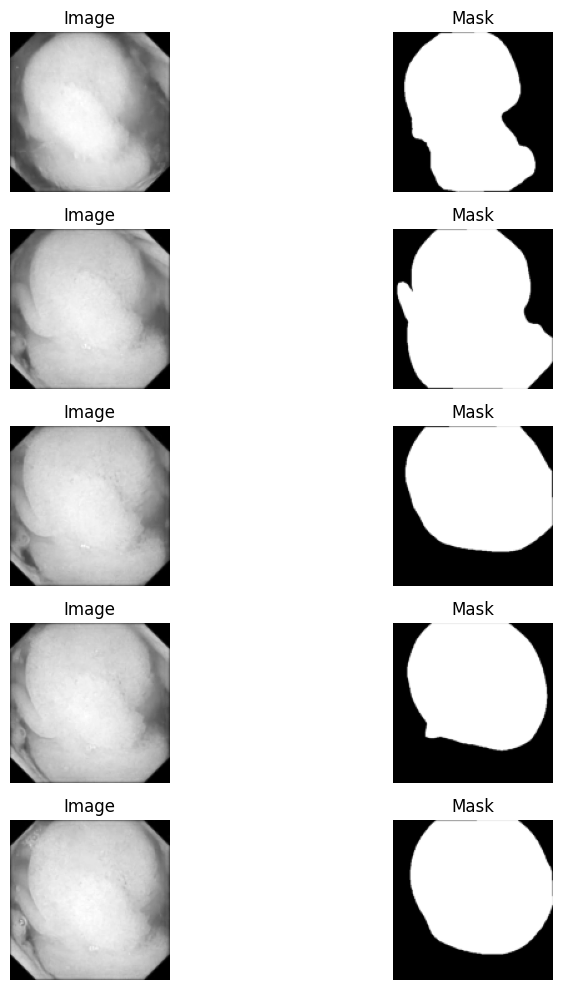

In [ ]:
def display_samples(images, masks, num_samples=5):
    plt.figure(figsize=(10, num_samples * 2))

    for i in range(num_samples):
        # Отображение изображения
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Image")
        plt.axis('off')

        # Отображение маски
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Вызов функции для отображения изображений и масок
display_samples(images, masks)


In [ ]:
print("Форма изображений:", images.shape)
print("Форма масок:", masks.shape)

# Проверка значений пикселей
print("Минимальное и максимальное значение пикселей изображений:", np.min(images), np.max(images))
print("Минимальное и максимальное значение пикселей масок:", np.min(masks), np.max(masks))

Форма изображений: (55, 128, 128, 1)
Форма масок: (55, 128, 128, 1)
Минимальное и максимальное значение пикселей изображений: 0.0 0.9888649935291602
Минимальное и максимальное значение пикселей масок: 0.0 0.9999999999999998


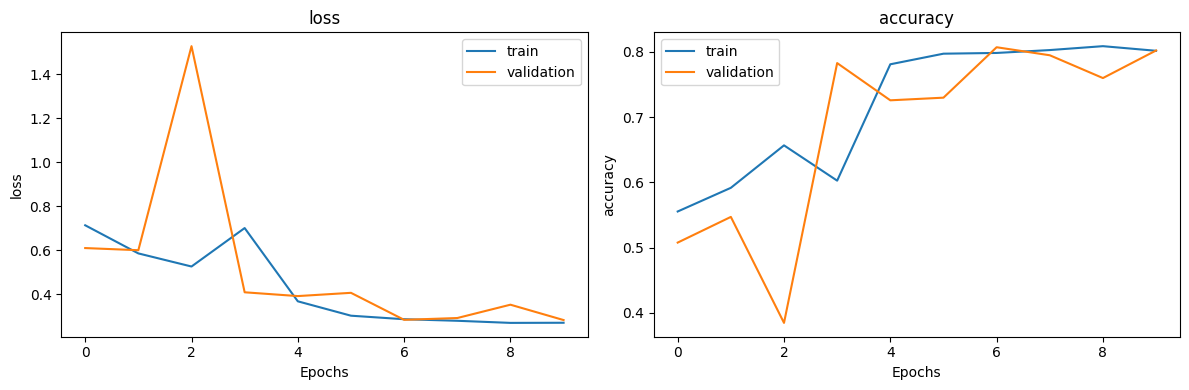

In [ ]:

def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend(['train', 'validation'])

    plt.tight_layout()
    plt.show()

# Вызов функции для визуализации метрик
plot_metrics(history)


В этом графике я заметил тренировочная функция потерь уменьшается, а валидационная резко уменьшается.Это может быть связано с тем что модель переобучилась.И поэтому я хочу попробовать Лассо регуляризацию.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def unet_model(input_size=(128, 128, 1), l2_lambda=0.001):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model
model2 = unet_model()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(images, masks, validation_split=0.2, epochs=10, batch_size=8)

Epoch 1/10
6/6 [==============================] - 8s 266ms/step - loss: 6.0375 - accuracy: 0.4910 - val_loss: 4.1394 - val_accuracy: 0.4941
Epoch 2/10
6/6 [==============================] - 1s 137ms/step - loss: 3.2433 - accuracy: 0.5702 - val_loss: 2.2621 - val_accuracy: 0.5335
Epoch 3/10
6/6 [==============================] - 1s 135ms/step - loss: 1.8266 - accuracy: 0.5963 - val_loss: 1.4009 - val_accuracy: 0.5561
Epoch 4/10
6/6 [==============================] - 1s 134ms/step - loss: 1.1471 - accuracy: 0.6985 - val_loss: 0.8805 - val_accuracy: 0.8014
Epoch 5/10
6/6 [==============================] - 1s 133ms/step - loss: 0.7874 - accuracy: 0.7959 - val_loss: 0.6682 - val_accuracy: 0.7982
Epoch 6/10
6/6 [==============================] - 1s 133ms/step - loss: 0.6273 - accuracy: 0.7990 - val_loss: 0.5746 - val_accuracy: 0.7933
Epoch 7/10
6/6 [==============================] - 1s 133ms/step - loss: 0.5215 - accuracy: 0.8093 - val_loss: 0.5147 - val_accuracy: 0.7874
Epoch 8/10
6/6 [====

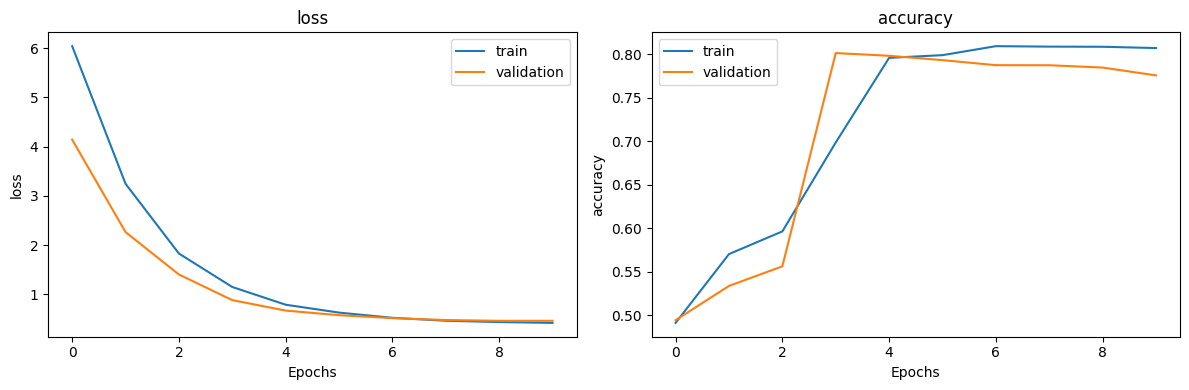

In [ ]:
plot_metrics(history2)

Лассо регуляризация как по мне не спасло ситуацию,либо я слишком подазрителен.Но все равно хочу попробовать дропаут

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def unet_model_with_dropout(input_size=(128, 128, 1), dropout_rate=0.2):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)  # Dropout после пулинга

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)  # Dropout после пулинга

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout_rate)(p3)  # Dropout после пулинга

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout_rate)(p4)  # Dropout после пулинга

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout_rate)(u6)  # Dropout перед конкатенацией
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout_rate)(u7)  # Dropout перед конкатенацией
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout_rate)(u8)  # Dropout перед конкатенацией
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout_rate)(u9)  # Dropout перед конкатенацией
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Создание и компиляция модели с Dropout
model_with_dropout = unet_model_with_dropout()
model_with_dropout.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history_dropout = model_with_dropout.fit(images, masks, validation_split=0.2, epochs=10, batch_size=8)


Epoch 1/10
6/6 [==============================] - 9s 227ms/step - loss: 0.6151 - accuracy: 0.5435 - val_loss: 0.6058 - val_accuracy: 0.5047
Epoch 2/10
6/6 [==============================] - 1s 148ms/step - loss: 0.5444 - accuracy: 0.5861 - val_loss: 0.5715 - val_accuracy: 0.5437
Epoch 3/10
6/6 [==============================] - 1s 149ms/step - loss: 0.4825 - accuracy: 0.6608 - val_loss: 0.4506 - val_accuracy: 0.6954
Epoch 4/10
6/6 [==============================] - 1s 147ms/step - loss: 0.9737 - accuracy: 0.6172 - val_loss: 0.5407 - val_accuracy: 0.6112
Epoch 5/10
6/6 [==============================] - 1s 147ms/step - loss: 0.4455 - accuracy: 0.7633 - val_loss: 0.4267 - val_accuracy: 0.8028
Epoch 6/10
6/6 [==============================] - 1s 149ms/step - loss: 0.3645 - accuracy: 0.8028 - val_loss: 0.2896 - val_accuracy: 0.8073
Epoch 7/10
6/6 [==============================] - 1s 148ms/step - loss: 0.2697 - accuracy: 0.8118 - val_loss: 0.3230 - val_accuracy: 0.7942
Epoch 8/10
6/6 [====

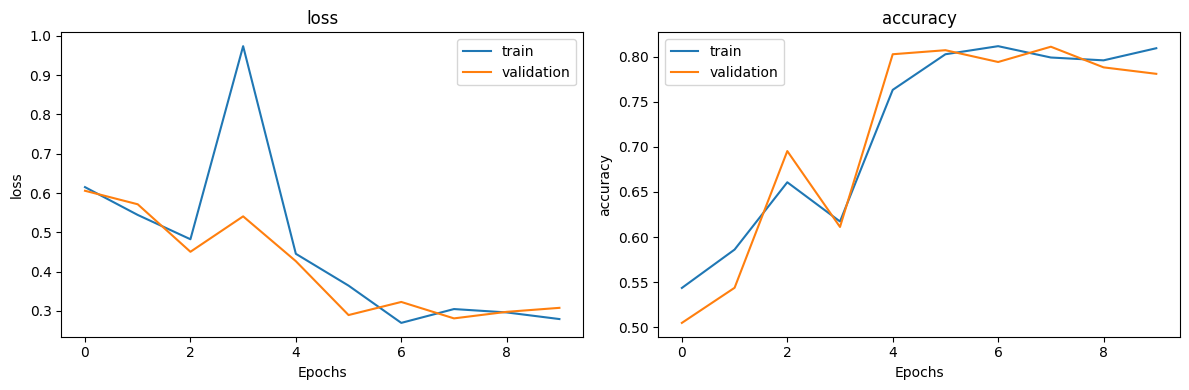

In [ ]:
plot_metrics(history_dropout)

Картина похож на то что преодолело переобучение

Как итог могу сказать что сегментация изображения ЖКТ по мне особо и не нужна. Но это сугубо моя клиническая практика показывает,патологические изменение в ЖКТ довольно заметны, риск упущение деталей минимален, если не считать некоторые моменты. Но это только мое мнение.